In [62]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets,transforms
from torchvision.utils import make_grid
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,accuracy_score
import numpy as np
%matplotlib inline

* The CIFAR-10 dataset consists of 60000 **32x32 colour images** in **10 classes**, with 6000 images per class. There are **50000 training** images and **10000 test** images.



In [23]:
class_names = ['plane', 'car', 'bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [24]:
def lossPlotting(train_losses,test_losses):
    train_losses_numpy = [loss.detach().numpy() for loss in train_losses]
    test_losses_numpy = [loss.detach().numpy() for loss in test_losses]

    # Now, you can plot the NumPy arrays
    plt.plot(train_losses_numpy, label='training loss')
    plt.plot(test_losses_numpy, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend()
    plt.show()

def evaluate_model_on_all_test_set(model):
    # Create a loader for the entire the test set
    test_load_all = DataLoader(testData, batch_size=10000, shuffle=False)

    with torch.no_grad():
        correct = 0
        for X_test, y_test in test_load_all:
            y_val = model(X_test)
            predicted = torch.max(y_val,1)[1]
            correct += (predicted == y_test).sum()
            
    return y_test,predicted

def confusion_metrix (y_test,predicted,class_names) :
    arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
    df_cm = pd.DataFrame(arr, class_names, class_names)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show();
    
def AccPrecitionRecallF1(y_test,predicted):
    precisionScore,recallScore,flScore,accuracy= [],[],[],[]
    
    dicPred = {i:[] for i in range(0,10)}
    actual = [1]*1000
    
    for i,j in zip(y_test.view(-1),predicted.view(-1)):
        i = i.item()
        if i == j :
            dicPred[i].append(1)
        else:
            dicPred[i].append(0)
        
    for i in range(0,10):
        accuracy.append(accuracy_score(actual,dicPred[i]))
        precisionScore.append(precision_score(dicPred[i],actual)) 
        recallScore.append(recall_score(actual,dicPred[i]))
        flScore.append(f1_score(dicPred[i],actual))
    
    return precisionScore,recallScore,flScore,accuracy

def plotting (score,class_names,title):
    sns.barplot(x=class_names ,y=score)
    plt.title(title)
    plt.show()


## Data Preprocessing

* In this section i did some transformations 
* First , I doubled checked that image size is 32
* Afterthat , I augmented data by making RandomHorizontalFlip and RandomRotation
* Finally , I normalized data by these mean and std as i many researchers used it as i make a faster converge

In [25]:
imgSize = 32 
mean , std = [0.485, 0.456, 0.406] , [0.229, 0.224, 0.225]  # I used these mean and std as i see many researchers used it as i make a faster converge

# Making transformation on data which are resizing , RandomHFlip , RandomRotation and Normalization
transformTrain = transforms.Compose([
    transforms.Resize((imgSize,imgSize)),
    transforms.RandomHorizontalFlip(), # default is .5
    transforms.RandomRotation(20) ,
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])


transformTest = transforms.Compose([
    transforms.Resize((imgSize,imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])


trainData = datasets.CIFAR10(root='./Cifar',train=True,download=True,transform=transformTrain)
testData = datasets.CIFAR10(root='./Cifar',train=False,download=True,transform=transformTest)




Files already downloaded and verified
Files already downloaded and verified


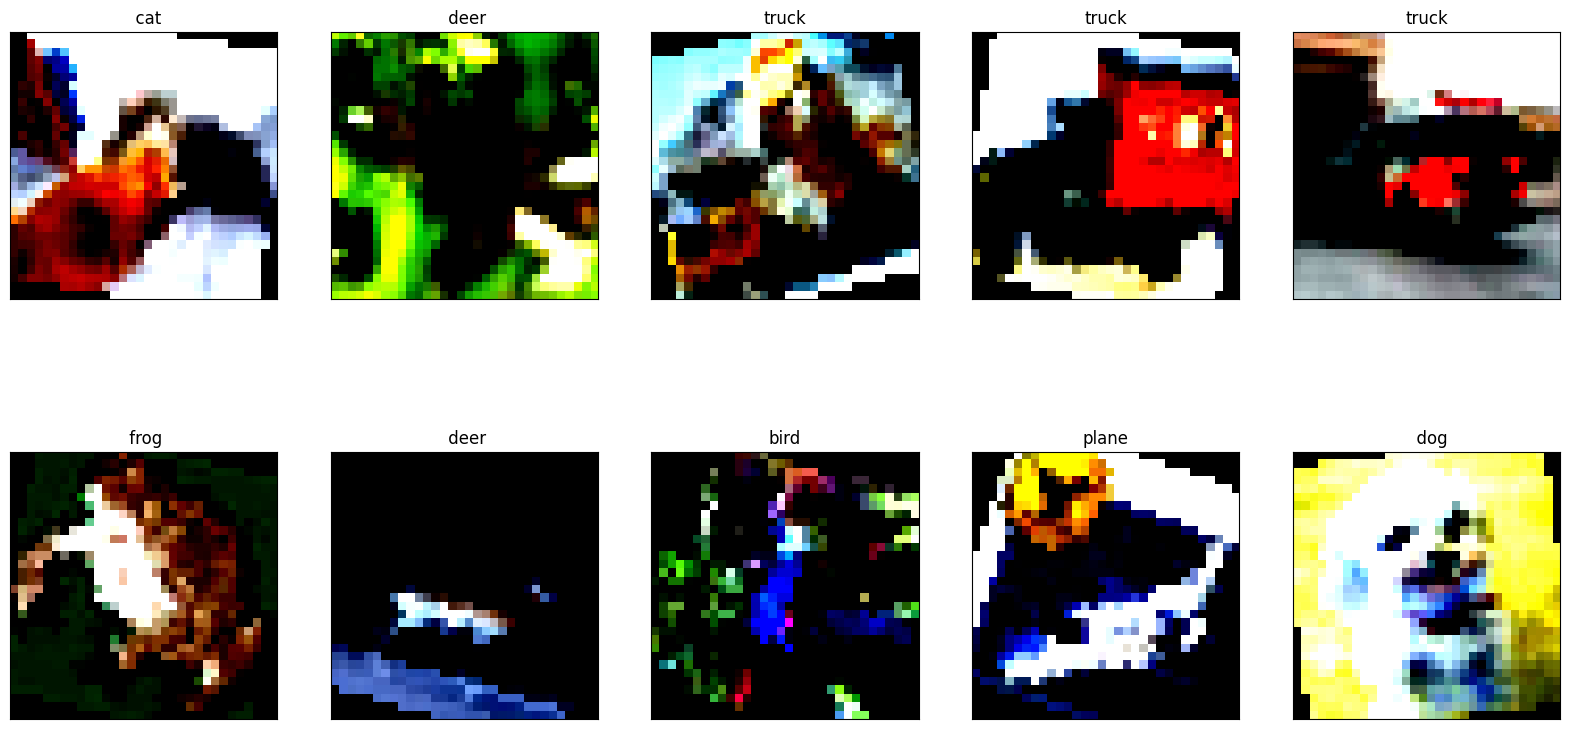

In [26]:
# Let's convert tensor image to numpy using im_convert function for imshow to print the img
def im_convert (im):
    return np.transpose(im.numpy(),(1,2,0))

fig = plt.figure(figsize=(20, 10)) 

for idx,j in zip (np.arange(10),np.random.randint(0,50000,10)):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    
    # Note: imshow cant print tensor !
    plt.imshow(im_convert(trainData[j][0]))
    ax.set_title(class_names[trainData[j][1]])


In [27]:
# Let's put train , validation data into batches 
trainLoader = torch.utils.data.DataLoader(dataset=trainData, batch_size=100)
testLoader = torch.utils.data.DataLoader(dataset=testData, batch_size=100)


## Model Building

**First trial**
* I created a model with 2 convolutions layers 
    * The first layer has 6 filters with kernel Size (3,3)
    * The second layer has 16 filters with kernel Size (4,4)
* After convlution layers , I made 3 fully connected layers
    

In [28]:
class Model(nn.Module):
    
    def __init__(self,outCo1=6,outCo2=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=outCo1,kernel_size=3,stride=1)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=outCo2,kernel_size=4,stride=1)
        self.fc1 = nn.Linear(16*5*5,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
        
    
    def forward(self,x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x,3,2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x,3,2)
        x = x.view(-1, 5*5*16)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        
        return f.log_softmax(x,dim=1)

In [29]:
model = Model()
modeCriterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
model

Model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Model Training and Evaluation

In [30]:
def trainingFunc(model,trainLoader,testLoader,epochs = 10):
    start_time = time.time()

    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0

        # Run the training batches
        for b, (X_train, y_train) in enumerate(trainLoader):
            b+=1

            # Apply the model
            y_pred = model(X_train)
            loss = modeCriterion(y_pred, y_train)

            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr

            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Print interim results
            if b%500 == 0:
                print(f'epoch: {i:2} loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(100*b):7.3f}%')

        train_losses.append(loss)
        train_correct.append(trn_corr)

        # Run the testing batches
        with torch.no_grad():
            for b, (X_test, y_test) in enumerate(testLoader):

                # Apply the model
                y_val = model(X_test)

                # Tally the number of correct predictions
                predicted = torch.max(y_val.data, 1)[1] 
                tst_corr += (predicted == y_test).sum()

        loss = modeCriterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)
         
    print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed 
    
    return train_losses,test_losses,train_correct,test_correct

In [31]:
train_losses,test_losses,train_correct,test_correct = trainingFunc(model,trainLoader,testLoader,epochs = 25)

epoch:  0 loss: 1.55369294 accuracy:  35.190%
epoch:  1 loss: 1.47041500 accuracy:  46.202%
epoch:  2 loss: 1.48105025 accuracy:  49.796%
epoch:  3 loss: 1.34738886 accuracy:  52.504%
epoch:  4 loss: 1.28480136 accuracy:  54.554%
epoch:  5 loss: 1.31008971 accuracy:  55.764%
epoch:  6 loss: 1.36546314 accuracy:  57.146%
epoch:  7 loss: 1.23086262 accuracy:  58.258%
epoch:  8 loss: 1.29977274 accuracy:  59.212%
epoch:  9 loss: 1.18091965 accuracy:  60.096%
epoch: 10 loss: 1.27844572 accuracy:  60.816%
epoch: 11 loss: 1.15146029 accuracy:  61.146%
epoch: 12 loss: 1.11416423 accuracy:  61.712%
epoch: 13 loss: 1.14037359 accuracy:  62.312%
epoch: 14 loss: 1.09042037 accuracy:  62.562%
epoch: 15 loss: 1.22785366 accuracy:  62.902%
epoch: 16 loss: 1.15786731 accuracy:  63.036%
epoch: 17 loss: 1.07129300 accuracy:  63.414%
epoch: 18 loss: 1.01538646 accuracy:  63.994%
epoch: 19 loss: 0.99683672 accuracy:  64.082%
epoch: 20 loss: 1.12367105 accuracy:  64.348%
epoch: 21 loss: 1.06947911 accurac

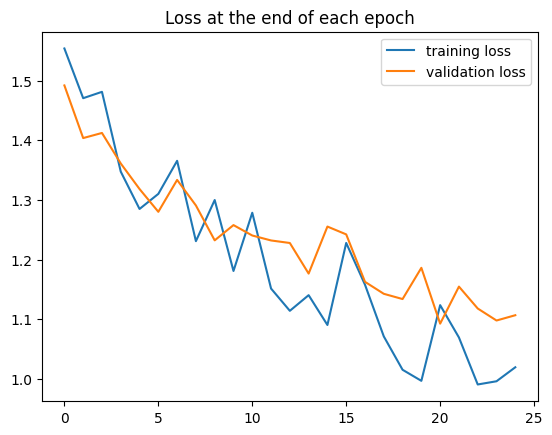

In [32]:
lossPlotting(train_losses,test_losses)

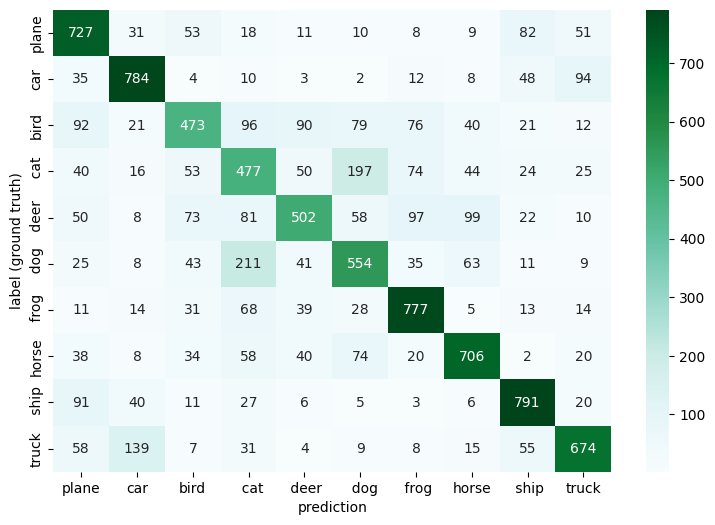

In [49]:
y_test,predicted = evaluate_model_on_all_test_set(model)
confusion_metrix (y_test,predicted,class_names)


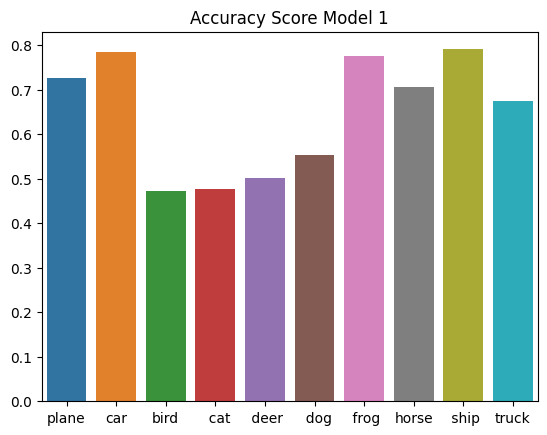

In [57]:
precisionScore,recallScore,flScore,accuracy = AccPrecitionRecallF1(y_test,predicted)
plotting (accuracy,class_names,'Accuracy Score Model 1')


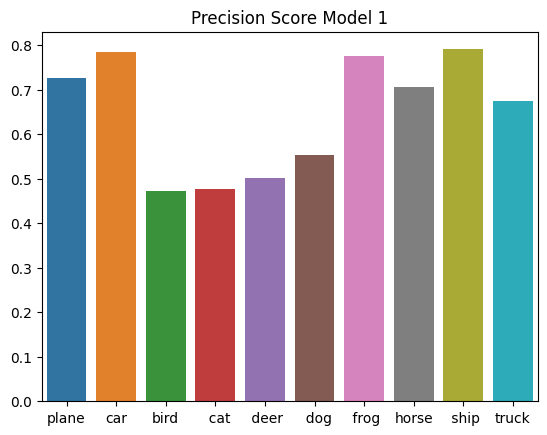

In [58]:
plotting (precisionScore,class_names,'Precision Score Model 1')

### Second Trial

* If we looked at the loss and accuracy previous trial 
    * If we trained our model with more epochs the acc will increase
    * Although after each epoch th acc increased but it increased slowly
        * we may play with learning rate of Adam optimizer
        * As momentum has less hyperparameters we may try it with lr .003
    * The accuracy of test is **65%** and on train **66%** so we can :
        * increased a number of filters of convolutions to get more details of the image which will increase the performance
        * use deeper convolution
        * increase the number of fully connected layer and if overfitting ocurred we will use dropout
     
        


In [35]:
class Model(nn.Module):
    
    def __init__(self,outCo1=16,outCo2=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=outCo1,kernel_size=5,stride=1) 
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=outCo2,kernel_size=5,stride=1) # ((32 - 5 + 1) - 3 / 2   +1) - 5 +1 -3 / 2 +1 =
        self.fc1 = nn.Linear(32*4*4,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,10)
        
    
    def forward(self,x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x,3,2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x,3,2)
        x = x.view(-1, 32*4*4)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        
        return f.log_softmax(x,dim=1)

In [36]:
model2 = Model()
modeCriterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [61]:
model2

Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [37]:
train_losses,test_losses,train_correct,test_correct = trainingFunc(model2,trainLoader,testLoader,epochs = 15)

epoch:  0 loss: 1.39517534 accuracy:  40.474%
epoch:  1 loss: 1.18289852 accuracy:  53.324%
epoch:  2 loss: 1.23909009 accuracy:  58.066%
epoch:  3 loss: 1.04555702 accuracy:  60.546%
epoch:  4 loss: 1.05293393 accuracy:  62.252%
epoch:  5 loss: 0.87094653 accuracy:  63.868%
epoch:  6 loss: 0.96682626 accuracy:  64.884%
epoch:  7 loss: 0.93652987 accuracy:  65.836%
epoch:  8 loss: 0.84612364 accuracy:  67.126%
epoch:  9 loss: 0.84665591 accuracy:  67.648%
epoch: 10 loss: 0.91928530 accuracy:  68.070%
epoch: 11 loss: 0.90643930 accuracy:  68.938%
epoch: 12 loss: 0.76733369 accuracy:  69.130%
epoch: 13 loss: 0.78023559 accuracy:  69.646%
epoch: 14 loss: 0.79930627 accuracy:  70.284%
Test accuracy: 70.400%

Duration: 673 seconds


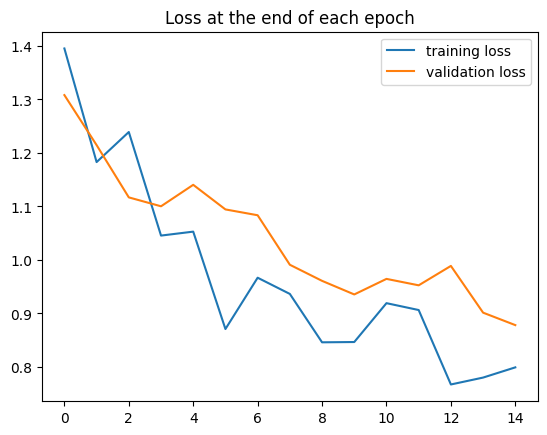

In [38]:
lossPlotting(train_losses,test_losses)

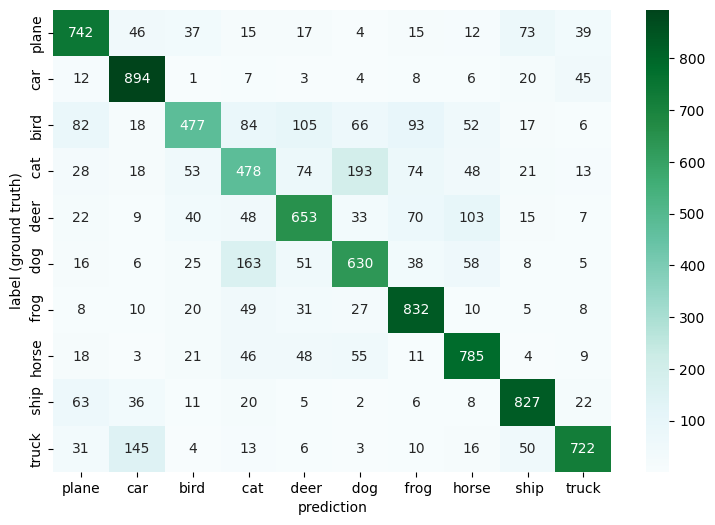

In [69]:
y_test,predicted = evaluate_model_on_all_test_set(model2)
confusion_metrix (y_test,predicted,class_names)


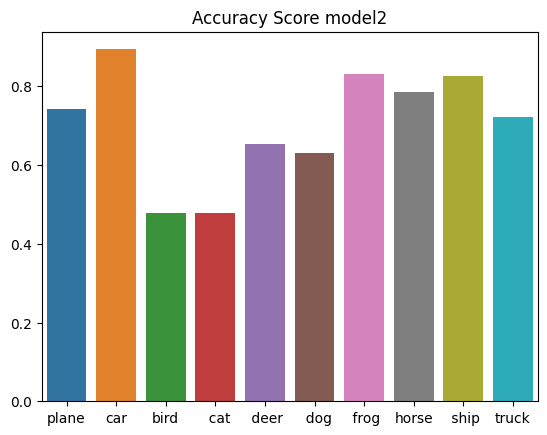

In [70]:
precisionScore,recallScore,flScore,accuracy = AccPrecitionRecallF1(y_test,predicted)
plotting (accuracy,class_names,'Accuracy Score model2')

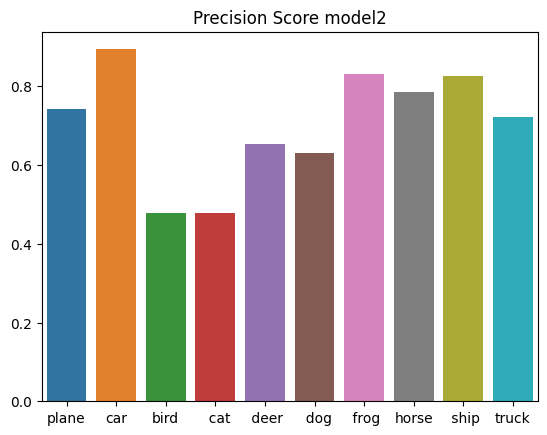

In [65]:
plotting (precisionScore,class_names,'Precision Score model2')

* Our Test score is **70%** and train score **69%**
* In this trial we acheived our goal with **15 epochs** we got results better than the previous model 
* And If we increased number of epochs we will get more better score

### Third Trial

* As i read in **Hands on Machine Learning** book to prevent the problem of saturating or explosion which in fact we didn't have them use **He** weights 
    * So what if we tried to use **He** weights initiallization and use nore neurons in our hidden layers
    
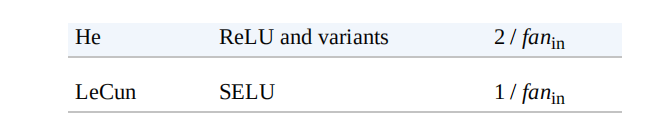

In [47]:
class Model(nn.Module):
    
    def __init__(self,outCo1=16,outCo2=32):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=outCo1,kernel_size=5,stride=1) 
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=outCo2,kernel_size=5,stride=1) # ((32 - 5 + 1) - 3 / 2   +1) - 5 +1 -3 / 2 +1 =
        self.fc1 = nn.Linear(32*4*4,512)
        torch.nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.fc2 = nn.Linear(512,256)
        torch.nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.fc3 = nn.Linear(256,10)
        torch.nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        
    
    def forward(self,x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x,3,2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x,3,2)
        x = x.view(-1, 32*4*4)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        
        return f.log_softmax(x,dim=1)

In [41]:
model3 = Model()
modeCriterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

In [48]:
model3

Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [42]:
train_losses,test_losses,train_correct,test_correct = trainingFunc(model3,trainLoader,testLoader,epochs = 15)

epoch:  0 loss: 1.38147807 accuracy:  44.908%
epoch:  1 loss: 1.20105886 accuracy:  55.510%
epoch:  2 loss: 1.19127285 accuracy:  59.614%
epoch:  3 loss: 1.07983577 accuracy:  62.332%
epoch:  4 loss: 1.07738423 accuracy:  64.420%
epoch:  5 loss: 0.94851005 accuracy:  65.822%
epoch:  6 loss: 0.97456789 accuracy:  67.246%
epoch:  7 loss: 0.97767329 accuracy:  68.226%
epoch:  8 loss: 0.92167211 accuracy:  69.422%
epoch:  9 loss: 0.85050613 accuracy:  70.076%
epoch: 10 loss: 0.82040429 accuracy:  70.998%
epoch: 11 loss: 0.77921277 accuracy:  71.828%
epoch: 12 loss: 0.81815451 accuracy:  72.512%
epoch: 13 loss: 0.71814561 accuracy:  73.138%
epoch: 14 loss: 0.80255163 accuracy:  73.630%
Test accuracy: 70.930%

Duration: 703 seconds


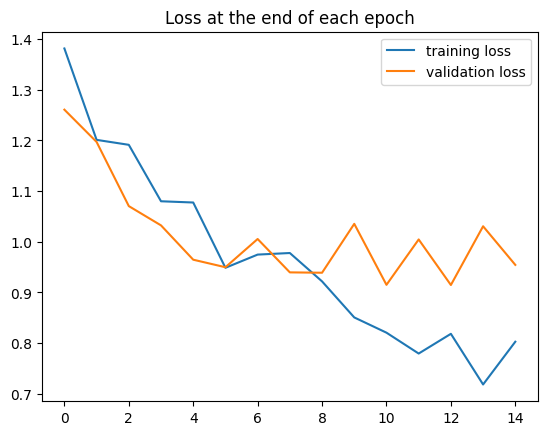

In [43]:
lossPlotting(train_losses,test_losses)

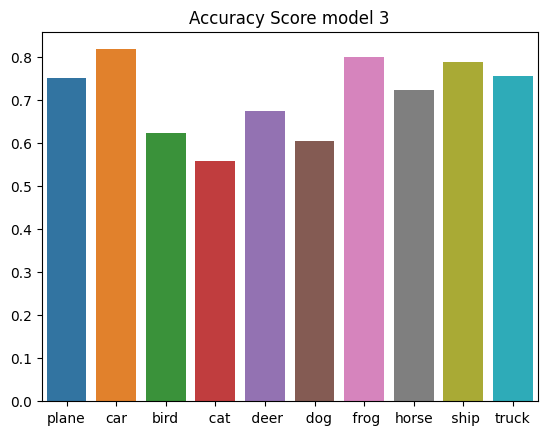

In [66]:
y_test,predicted = evaluate_model_on_all_test_set(model3)
precisionScore,recallScore,flScore,accuracy = AccPrecitionRecallF1(y_test,predicted)
plotting (accuracy,class_names,'Accuracy Score model 3')

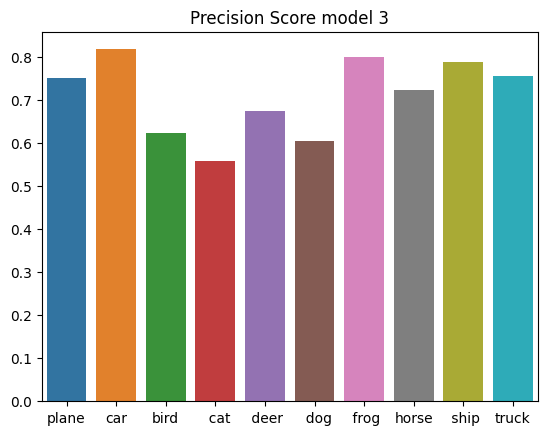

In [68]:
plotting (precisionScore,class_names,'Precision Score model 3')